In [5]:
import codecs
import glob
import gzip
from datetime import datetime
import dateparser
from multiprocessing import Pool

import string 
import xmltodict
import gensim
from nltk.corpus import stopwords
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.word2vec import LineSentence

import spacy
nlp = spacy.load('en')

from pymongo import MongoClient 

In [2]:
%%time

line_delim = '\\new'

with open('data/stopwords', encoding='utf-8') as fp:
    stopwords = fp.read().split('\n')
    
exclude = ["’s", "'s", "-PRON-", "'''", "``", "–", "‘a", "--", "..."]
stopwords.extend(exclude)
stopwords.extend(list(string.punctuation))
print(len(stopwords))

766
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 391 µs


In [3]:
%%time

   
dataset = 'all'
# dataset = 'karbala'

def xml_to_tuple(path):
    
    path = path + '*.xml'
    print(path)
    doc_num = 0
    doc_list = []
    for fname in glob.glob(path):

        with codecs.open(fname, encoding='utf_8') as doc_file:

            try:
                doc = xmltodict.parse(doc_file.read())
                doc_list.append(
                    [doc['Document']['Id'],
                    str(dateparser.parse(doc['Document']['PublicationDateTime'])),
                    doc['Document']['Text'].replace('\r', line_delim).replace('\n', line_delim)]
                )
                doc_num += 1
            except Exception as e: 
                pass
            
    print (u'Finished parsing text from %s, number of docs {:,} '.format(doc_num) % path)

    return doc_list


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.29 µs


In [5]:
%%time


def execute_xml_to_txt(file_list, txt_filepath):
        
    
    pool = Pool(processes=7)              # start 7 worker processes
    doc_text = pool.map(xml_to_tuple, file_list)
    
    doc_text = [val for sublist in doc_text for val in sublist]
    
    doc_txt_file = gzip.open(txt_filepath, 'w')
    for doc in doc_text:
        doc_txt_file.write('\t'.join(doc).encode("utf-8") + '\n'.encode("utf-8"))
    
    doc_txt_file.close()
    print ("number of documents parsed: {}".format(len(doc_text)) )
    
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


In [6]:
%%time


txt_filepath = 'data/eos/ngram/eos_text_%s.gz' % dataset
path = '/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/*/'

file_list = glob.glob(path)

# run this function to write plain text from xml to gz file    
execute_xml_to_txt(file_list, txt_filepath)

/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Erbil/*.xml
/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Sulaymaniya/*.xml
/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Anbar/*.xml
/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Salah Ad Din/*.xml
/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Al Muthanna/*.xml
/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Ninewa/*.xml
/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Dohuk/*.xml
Finished parsing text from /home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Dohuk/*.xml, number of docs 9,720 
/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Karbala/*.xml
Finished parsing text from /home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/Al Muthanna/*.xml, number of docs 9,927 
/home/sonic/sonic/EOS_DATA/XML_Export_6-8-

Iterate over the docs in the review_txt_all.txt we created before

Segment the reviews into individual sentences

Remove punctuation and excess whitespace

Lemmatize the text

In [7]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace, less than 2 characters
    """
    
    return token.is_punct or token.is_space or (len(token.orth_) < 2)

def line_review(filename):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """

    with gzip.open(filename, 'r') as f:
        for review in f:
            yield review.decode().replace(line_delim, '\n') #return text

            
def line_text_review(filename):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """

    with gzip.open(filename, 'r') as f:
        for review in f:
            yield review.decode().replace(line_delim, '\n').split('\t')[2] #return text
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in nlp.pipe(line_text_review(filename),
                                  batch_size=10000, n_threads=7):

        for sent in parsed_review.sents:
            yield (u' '.join([token.lemma_ for token in sent if not punct_space(token)]))

In [8]:
%%time


unigram_sentences_filepath = 'data/eos/ngram/unigram_sentences_%s.gz' 
bigram_model_filepath = 'data/eos/ngram/bigram_model_%s' % dataset
bigram_sentences_filepath = 'data/eos/ngram/bigram_sentences_%s.txt' % dataset


# Document doesn't matter anymore, this is collection level sentences
def text_unigram(review_txt_filepath, unigram_sentences_filepath):
    
    print("Start modeling unigrams " + datetime.now().strftime("%H:%M:%S"))
    
    f = gzip.open(unigram_sentences_filepath, 'w')

    for sentence in lemmatized_sentence_corpus(review_txt_filepath):
        f.write(sentence.encode("utf-8") + '\n'.encode("utf-8"))  
        
    f.close()
    print("finished modeling unigrams " + datetime.now().strftime("%H:%M:%S"))
    


def text_bigram(unigram_sentences_filepath):
    
    print ("starting modeling bigrams " + datetime.now().strftime("%H:%M:%S") + unigram_sentences_filepath)
    unigram_sentences = LineSentence(unigram_sentences_filepath)

    bigram_model = gensim.models.Phrases(unigram_sentences)

    bigram_model.save(bigram_model_filepath)
    # load the finished model from disk
    # bigram_model = Phraser.load(bigram_model_filepath)
    
    # Write collection sentences    
    f = gzip.open(bigram_sentences_filepath, 'w')
    for unigram_sentence in unigram_sentences:
        bigram_sentence = u' '.join(bigram_model[unigram_sentence])
        f.write(bigram_sentence.encode("utf-8") + '\n'.encode("utf-8"))
        
    f.close()
        
    print ("finished modeling bigrams " + datetime.now().strftime("%H:%M:%S"))
    return bigram_model

            

def text_trigram():
    print ("start modeling trigrams " + datetime.now().strftime("%H:%M:%S"))
    bigram_sentences = LineSentence(bigram_sentences_filepath)
    trigram_model = gensim.models.Phrases(bigram_sentences)
    trigram_model.save(trigram_model_filepath)
    # load the finished model from disk
    # trigram_model = Phraser.load(trigram_model_filepath)

    with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for bigram_sentence in bigram_sentences:
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            f.write(trigram_sentence + '\n')
            
    print ("finished modeling trigrams " + datetime.now().strftime("%H:%M:%S"))
    return trigram_model


def text_ngram_token(review_txt_filepath, final_doc_filepath):
    
    unigram_filepath = unigram_sentences_filepath % dataset
    text_unigram(review_txt_filepath, unigram_filepath) # Turn on/off
    bigram_model = text_bigram(unigram_filepath) # Turn on/off
#     bigram_model = Phraser.load(bigram_model_filepath)
#     trigram_model = text_trigram() # Turn on/off
#     trigram_model = Phraser.load(trigram_model_filepath)
    
    doc_num = 0
    doc_id = ''
    doc_date = ''
    doc_list = []
    
    print ("Starting modeling ngrams " + datetime.now().strftime("%H:%M:%S"))
    
    for parsed_review in nlp.pipe(line_review(review_txt_filepath),
                                  batch_size=10000, n_threads=7):

        doc_id = parsed_review.text.split('\t')[0]
        doc_date = parsed_review.text.split('\t')[1]
        
        # lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in nlp(parsed_review.text.split('\t')[2])
                          if not punct_space(token)]

        if (len(unigram_review) < 5 or len(unigram_review) > 3000):
            continue

        # apply the first-order and second-order phrase models
        ngram_doc = bigram_model[unigram_review]
#             ngram_doc = trigram_model[ngram_doc]


        # remove any remaining stopwords and exclude list
        ngram_doc = [term for term in ngram_doc
                          if term not in stopwords]

        # write the transformed review as a line in the new file
        doc_list.append(doc_id + '\t' + u' '.join(ngram_doc))
        
    
    f = gzip.open(final_doc_filepath, 'w')       
    for doc in doc_list:
        f.write(doc.encode("utf-8") + '\n'.encode("utf-8"))
    f.close()
            
    print ("finished modeling ngrams, {} documents processed ".format(doc_num) + datetime.now().strftime("%H:%M:%S"))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


In [4]:
%%time


review_txt_filepath = 'data/eos/ngram/eos_text_%s.gz' % dataset
# Ngram document/line 
final_doc_filepath = 'data/eos/ngram/bigram_transformed_docs_%s.txt' % dataset
text_ngram_token(review_txt_filepath, final_doc_filepath)

NameError: name 'dataset' is not defined

In [10]:
%%time 


dictionary_filepath = 'data/eos/ngram/bigram_dict_%s.dict' % dataset
bow_filepath = 'data/eos/ngram/bigram_bow_corpus_%s.mm' % dataset


def build_dict ():
    
    print ("start dictionary " + datetime.now().strftime("%H:%M:%S"))
    docs = LineSentence(final_doc_filepath)

    # learn the dictionary by iterating over all of the reviews
    dictionary = Dictionary(docs)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    dictionary.filter_extremes(no_below=5)
    dictionary.compactify()

    dictionary.save(dictionary_filepath)
    print ("finished dictionary " + datetime.now().strftime("%H:%M:%S"))
    return dictionary
    
    
def doc2bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for doc in LineSentence(filepath):
        yield dictionary.doc2bow(doc)

# Generate dictionary       
dictionary = build_dict ()      
    
# generate bag-of-words representations for
# all reviews and save them as a matrix
MmCorpus.serialize(bow_filepath, doc2bow_generator(final_doc_filepath))

corpus = MmCorpus(bow_filepath)

print(dictionary)
print(corpus)

start dictionary 23:34:46
finished dictionary 23:37:25
Dictionary(100000 unique tokens: ['kcci_strive', 'mafia_scandal', 'fahrenheit_above', 'mercado', 'satrap']...)
MmCorpus(460187 documents, 100000 features, 86073196 non-zero entries)
CPU times: user 6min 18s, sys: 2.65 s, total: 6min 21s
Wall time: 6min 21s


In [12]:
%%time


tf_idf_filepath = 'data/eos/ngram/tf_idf_%s.model' % dataset
tfidf = gensim.models.TfidfModel(corpus)
tfidf.save(tf_idf_filepath)

CPU times: user 2min 59s, sys: 1.22 s, total: 3min
Wall time: 2min 57s


data/eos/ngram/unigram_sentences_final_all.gz
460187
2275
2


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<IPython.core.display.Javascript object>


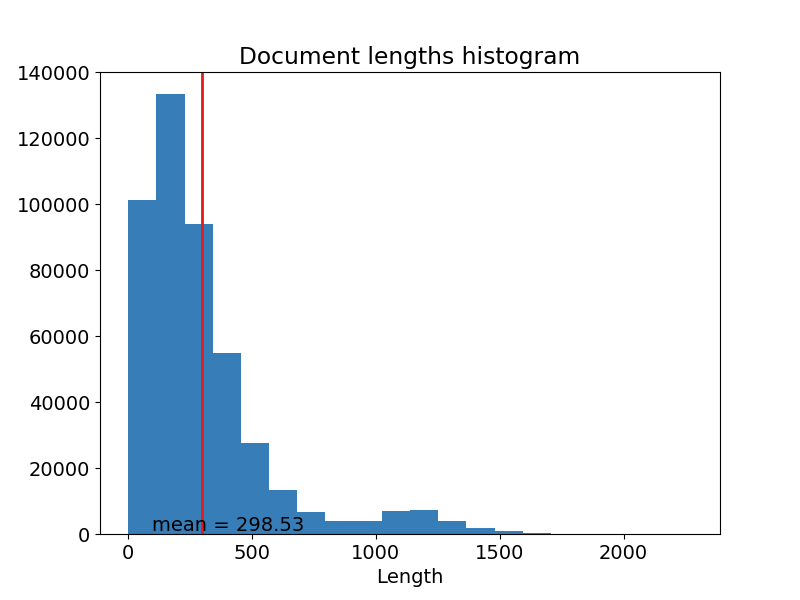

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


CPU times: user 23.7 s, sys: 2.03 s, total: 25.7 s
Wall time: 25.6 s


In [3]:
%%time 


from matplotlib import pyplot as plt
%matplotlib notebook


def corpus_info(filepath):
    
    corpus = []

    with gzip.open(filepath, 'r') as f:
        for line in f:
            corpus.append(line.decode().split(' '))
        
    # Document lengths.
    lens = [len(doc) for doc in corpus]

    print(len(lens))
#     print(corpus[10])

    print(len(max(corpus, key=len)))
    print(len(min(corpus, key=len)))

    # Plot.
    plt.rc('figure', figsize=(8, 6))
    plt.rc('font', size=14)
    plt.rc('lines', linewidth=2)
    plt.rc('axes', color_cycle=('#377eb8', '#e41a1c', '#4daf4a',
                                '#984ea3', '#ff7f00', '#ffff33'))
    # Histogram.
    plt.hist(lens, bins=20)
    plt.hold(True)
    # Average length.
    avg_len = sum(lens) / float(len(lens))
    plt.axvline(avg_len, color='#e41a1c')
    plt.hold(False)
    plt.title('Document lengths histogram')
    plt.xlabel('Length')
    plt.text(100, 800, 'mean = %.2f' % avg_len)
    plt.show()

    
final_doc_filepath = 'data/eos/ngram/unigram_sentences_final_%s.gz' % 'all'
print(final_doc_filepath)
corpus_info(final_doc_filepath)